In [1]:
# Quantum-Classical Hybrid Model using BERT and Quantum Kernel SVM for GoEmotions Dataset

# Step 1: Environment Setup (Google Colab)
!pip uninstall -y jax jaxlib
!pip install jax==0.4.28 jaxlib==0.4.28 --quiet
!pip install pennylane seaborn tensorflow-datasets scikit-learn==1.6.1 transformers --upgrade --quiet

Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: jaxlib 0.5.1
Uninstalling jaxlib-0.5.1:
  Successfully uninstalled jaxlib-0.5.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 MB 7.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbax-checkpoint 0.11.16 requires jax>=0.5.0, but you have jax 0.4.28 which is incompatible.
flax 0.10.6 requires jax>=0.5.1, but you have jax 0.4.28 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10

In [2]:
# Step 2: Import Required Libraries
import pennylane as qml
from pennylane import numpy as np
import numpy as onp
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from transformers import BertTokenizer, BertModel
import tensorflow_datasets as tfds
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Step 3: Load GoEmotions Dataset
print("Loading GoEmotions dataset...")
dataset, info = tfds.load('goemotions', with_info=True)
train_dataset = dataset['train']

# Define emotion labels in the correct order
emotion_labels = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
    'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment',
    'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'neutral',
    'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise'
]

texts, labels = [], []
for example in tfds.as_numpy(train_dataset):
    texts.append(example['comment_text'].decode('utf-8'))
    for idx, label in enumerate(emotion_labels):
        if example[label]:
            labels.append(idx)
            break
    else:
        labels.append(20)

n_classes = 28

Loading GoEmotions dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/goemotions/incomplete.VFBNZ3_0.1.0/goemotions-train.tfrecord*...:   0%|   …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/goemotions/incomplete.VFBNZ3_0.1.0/goemotions-validation.tfrecord*...:   0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/goemotions/incomplete.VFBNZ3_0.1.0/goemotions-test.tfrecord*...:   0%|    …

Dataset goemotions downloaded and prepared to /root/tensorflow_datasets/goemotions/0.1.0. Subsequent calls will reuse this data.


In [4]:
# Step 4: BERT Embedding Extraction
print("Extracting BERT embeddings...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to compute BERT [CLS] embeddings
def bert_embed(sentences):
    with torch.no_grad():
        inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True, max_length=128)
        outputs = model(**inputs)
        return outputs.last_hidden_state[:, 0, :].numpy()

batch_size = 64
bert_embeddings = []
for i in range(0, len(texts), batch_size):
    bert_embeddings.append(bert_embed(texts[i:i+batch_size]))
X = onp.vstack(bert_embeddings)
y = onp.array(labels)

Extracting BERT embeddings...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:
# Step 5: Dimensionality Reduction
print("Reducing BERT embedding dimensions using PCA...")
pca = PCA(n_components=16)
X_reduced = pca.fit_transform(X)

# Limit dataset to 5000 samples for computational feasibility
X = X[:250]
y = y[:250]

# Step 5: Dimensionality Reduction
print("Reducing BERT embedding dimensions using PCA...")
pca = PCA(n_components=16)
X_reduced = pca.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

Reducing BERT embedding dimensions using PCA...
Reducing BERT embedding dimensions using PCA...


In [8]:
# Step 6: Quantum Kernel Setup
n_qubits = 16
dev = qml.device('default.qubit', wires=n_qubits)

def feature_map(x):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[n_qubits - 1, 0])

@qml.qnode(dev)
def kernel_circuit(x1, x2):
    feature_map(x1)
    qml.adjoint(feature_map)(x2)
    return qml.probs(wires=range(n_qubits))

# Quantum kernel function
from tqdm import tqdm

import pickle

def quantum_kernel(X1, X2):
    kernel = np.zeros((len(X1), len(X2)))
    for i in tqdm(range(len(X1)), desc='Computing quantum kernel rows'):
        if i % (len(X1) // 15) == 0 and i != 0:
            with open(f'kernel_checkpoint_row_{i}.pkl', 'wb') as f:
                pickle.dump(kernel, f)
            print(f'Checkpoint saved at row {i}')
        for j in range(len(X2)):
            kernel[i, j] = np.abs(kernel_circuit(X1[i], X2[j])[0])
    return kernel


In [9]:
# Step 7: Compute Quantum Kernel Matrices
print("Computing quantum kernel matrices...")
K_train = quantum_kernel(X_train, X_train)
K_test = quantum_kernel(X_test, X_train)

Computing quantum kernel matrices...


Computing quantum kernel rows:   6%|▋         | 13/200 [03:16<45:55, 14.74s/it]

Checkpoint saved at row 13


Computing quantum kernel rows:  13%|█▎        | 26/200 [06:27<42:25, 14.63s/it]

Checkpoint saved at row 26


Computing quantum kernel rows:  20%|█▉        | 39/200 [09:41<40:05, 14.94s/it]

Checkpoint saved at row 39


Computing quantum kernel rows:  26%|██▌       | 52/200 [12:52<36:15, 14.70s/it]

Checkpoint saved at row 52


Computing quantum kernel rows:  32%|███▎      | 65/200 [16:05<34:15, 15.23s/it]

Checkpoint saved at row 65


Computing quantum kernel rows:  39%|███▉      | 78/200 [19:15<29:53, 14.70s/it]

Checkpoint saved at row 78


Computing quantum kernel rows:  46%|████▌     | 91/200 [22:26<26:40, 14.69s/it]

Checkpoint saved at row 91


Computing quantum kernel rows:  52%|█████▏    | 104/200 [25:41<23:50, 14.90s/it]

Checkpoint saved at row 104


Computing quantum kernel rows:  58%|█████▊    | 117/200 [28:52<20:13, 14.63s/it]

Checkpoint saved at row 117


Computing quantum kernel rows:  65%|██████▌   | 130/200 [32:05<17:32, 15.04s/it]

Checkpoint saved at row 130


Computing quantum kernel rows:  72%|███████▏  | 143/200 [35:16<14:00, 14.74s/it]

Checkpoint saved at row 143


Computing quantum kernel rows:  78%|███████▊  | 156/200 [38:28<10:40, 14.56s/it]

Checkpoint saved at row 156


Computing quantum kernel rows:  84%|████████▍ | 169/200 [41:41<07:44, 14.98s/it]

Checkpoint saved at row 169


Computing quantum kernel rows:  91%|█████████ | 182/200 [44:53<04:20, 14.48s/it]

Checkpoint saved at row 182


Computing quantum kernel rows:  98%|█████████▊| 195/200 [48:09<01:15, 15.19s/it]

Checkpoint saved at row 195


Computing quantum kernel rows:   6%|▌         | 3/50 [00:45<11:57, 15.26s/it]

Checkpoint saved at row 3


Computing quantum kernel rows:  12%|█▏        | 6/50 [01:28<10:41, 14.57s/it]

Checkpoint saved at row 6


Computing quantum kernel rows:  18%|█▊        | 9/50 [02:11<09:49, 14.37s/it]

Checkpoint saved at row 9


Computing quantum kernel rows:  24%|██▍       | 12/50 [02:54<09:08, 14.43s/it]

Checkpoint saved at row 12


Computing quantum kernel rows:  30%|███       | 15/50 [03:39<08:42, 14.92s/it]

Checkpoint saved at row 15


Computing quantum kernel rows:  36%|███▌      | 18/50 [04:23<07:47, 14.61s/it]

Checkpoint saved at row 18


Computing quantum kernel rows:  42%|████▏     | 21/50 [05:06<06:58, 14.45s/it]

Checkpoint saved at row 21


Computing quantum kernel rows:  48%|████▊     | 24/50 [05:51<06:31, 15.06s/it]

Checkpoint saved at row 24


Computing quantum kernel rows:  54%|█████▍    | 27/50 [06:35<05:37, 14.67s/it]

Checkpoint saved at row 27


Computing quantum kernel rows:  60%|██████    | 30/50 [07:18<04:51, 14.55s/it]

Checkpoint saved at row 30


Computing quantum kernel rows:  66%|██████▌   | 33/50 [08:02<04:06, 14.53s/it]

Checkpoint saved at row 33


Computing quantum kernel rows:  72%|███████▏  | 36/50 [08:48<03:28, 14.89s/it]

Checkpoint saved at row 36


Computing quantum kernel rows:  78%|███████▊  | 39/50 [09:31<02:40, 14.61s/it]

Checkpoint saved at row 39


Computing quantum kernel rows:  84%|████████▍ | 42/50 [10:14<01:55, 14.43s/it]

Checkpoint saved at row 42


Computing quantum kernel rows:  90%|█████████ | 45/50 [11:01<01:15, 15.12s/it]

Checkpoint saved at row 45


Computing quantum kernel rows:  96%|█████████▌| 48/50 [11:44<00:29, 14.67s/it]

Checkpoint saved at row 48


Computing quantum kernel rows: 100%|██████████| 50/50 [12:13<00:00, 14.67s/it]


In [10]:
# Step 8: Train SVM with Precomputed Quantum Kernel
print("Training Quantum Kernel SVM...")
svm = SVC(kernel='precomputed')
svm.fit(K_train, y_train)

Training Quantum Kernel SVM...


SVC(kernel='precomputed')

In [11]:
# Step 9: Evaluation
y_pred = svm.predict(K_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

print("Detailed Classification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.28
Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          20       0.28      1.00      0.44        14
          21       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         1
          23       0.00      0.00      0.00         1
          27       0.00      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


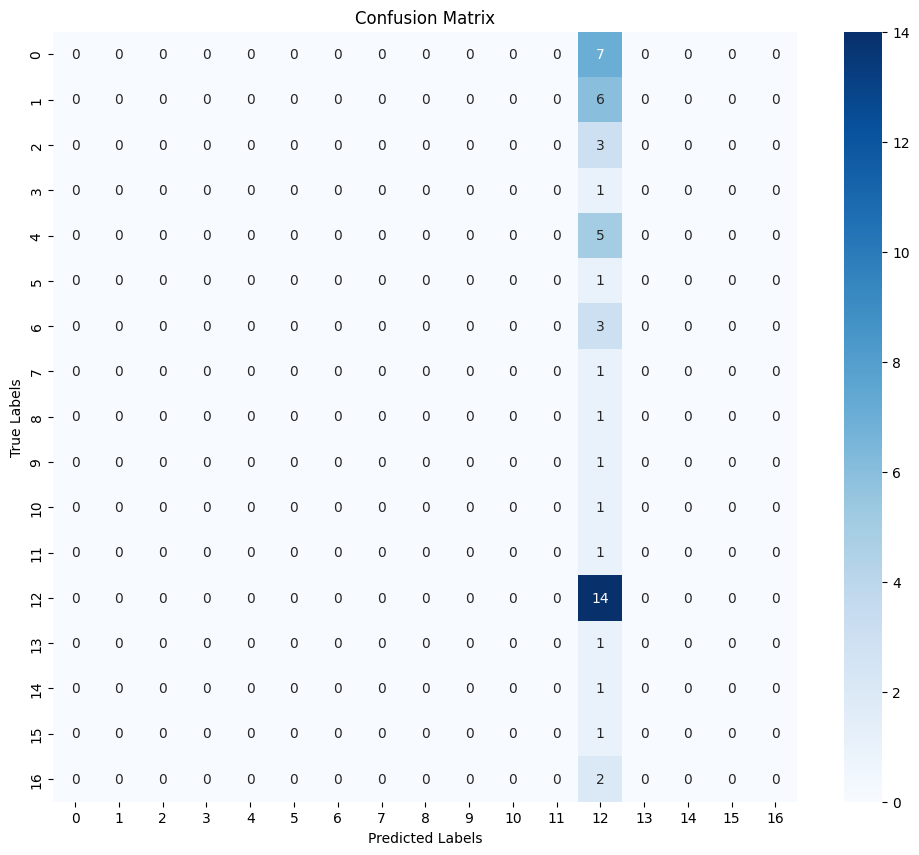

In [12]:
# Step 10: Confusion Matrix Plot
plt.figure(figsize=(12,10))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

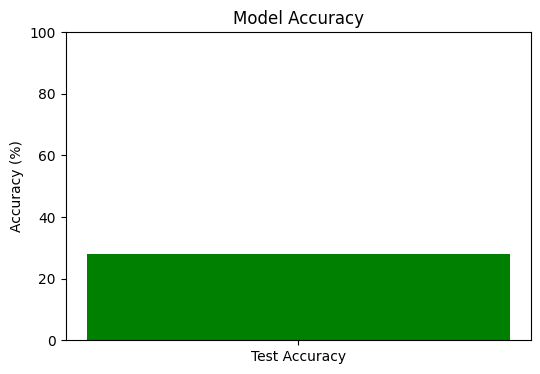

In [13]:
# Step 11: Accuracy Plot
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy'], [accuracy * 100], color='green')
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy')
plt.show()